In [53]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.vectorstores import Pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone as PC
from pinecone import ServerlessSpec
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import glob
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import FileSystemBlobLoader
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import PyPDFParser
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import uuid
from openai import OpenAI #Deprecated because i can't use his API(needs money)
from ollama import Client

In [54]:
#gerar n versoes da pergunta
#criar novos docs a partir do artigo, categorizados

In [55]:
loader = DirectoryLoader(
    "./rag-projeto/data",
    glob="*.pdf",
    loader_cls=PyPDFLoader
)

In [56]:
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Tamanho máximo de cada pedaço
    chunk_overlap=50 # Sobreposição entre pedaços
)
docs_splitted = text_splitter.split_documents(docs)

texts = [doc.page_content for doc in docs_splitted]
#criar ID para rastrear os vetores
ids = [str(uuid.uuid4()) for _ in range(len(texts))]
#Apaga todos os vetores mas mantem o index criado
#index.delete(delete_all=True)

In [57]:

os.environ['PINECONE_API_KEY'] = 'pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST'


In [58]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts, show_porgress_bar=True)

In [59]:
index_name = "rag"
pc = PC(api_key="pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST")
index = pc.Index(index_name)

In [60]:
embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", cache_folder="./ModeltoEmbedding"
)
#texts eh uma lista de strings onde cada string é um documento.Essa função gera os embeddings
embeddings= embedder.embed_documents(texts)
# Associar os embeddings com seus IDs
vectors = [(ids[i], embeddings[i]) for i in range(len(embeddings))]
# Inserir os embeddings no Pinecone (upsert)
index.upsert(vectors=vectors)

#vectorstore = PineconeVectorStore.from_documents(docs_splitted, embedder, index_name=index_name)
index.describe_index_stats()


{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 7544}},
 'total_vector_count': 7544,
 'vector_type': 'dense'}

In [61]:
query = "Quais os Principais Tipos de Diabetes?"


#Funçao do pinecone que já realiza a busca
# similar_docs = vectorstore.similarity_search(query, k=5)
#função para pegar o embedding do query
query_embedding = embedder.embed_query(query)

In [62]:

#Resultado do metodo de busca padrao.
# similar_docs
print(index)


In [63]:
#Implementando uma busca personalizada
#Baseando-se na busca de similaridade por cosseno , para mais detalhes: https://pt.wikipedia.org/wiki/Produto_escalar
#Tem esse estudo falando sobre o problema deste método que é interessante: https://www.shaped.ai/blog/cosine-similarity-not-the-silver-bullet-we-thought-it-was
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Calcular similaridade entre a consulta e todos os documentos
similarities = [cosine_similarity(query_embedding,doc_embedding) for doc_embedding in embeddings]
# Ordenar os índices dos documentos pela similaridade de forma decrescente
sorted_indices = np.argsort(similarities)[::-1]

# Obter os documentos mais semelhantes (top 5)
top_k = 100
top_docs = [texts[i] for i in sorted_indices[:top_k]]
top_similarities = [similarities[i] for i in sorted_indices[:top_k]]
top_embeddings = [embeddings[i] for i in sorted_indices[:top_k]]
# Exibir os resultados
for doc, sim in zip(top_docs, top_similarities):
    print(f"Similaridade: {sim:.4f}")
    print(f"Documento: {doc[:1000]}...")  # Exibir os primeiros 200 caracteres do documento
    print("-" * 50)


Similaridade: 0.7803
Documento:     Selvin E, Steffes MW, Gregg E, Brancati FL, Coresh J. Performance of A1C for
the classi cation and prediction of diabetes. Diabetes Care. 2011 Jan;34(1) 84-
9. doi: 10.2337/dc10-1235. 
    Kumar PR, Bhansali A, Ravikiran M, Bhansali S, Dutta P, Thakur JS, et al. Utility
of glycated hemoglobin in diagnosing type 2 diabetes mellitus: a community-
based study. J Clin Endocrinol Metab. 2010 Jun 1;95(6) 2832–5. 
    Kramer CK, Araneta MRG, Barrett-Connor E. A1C and diabetes diagnosis: The...
--------------------------------------------------
Similaridade: 0.7665
Documento: 5. The Diabetes Control and Complications Trial Research Group. The Effect of
Intensive Treatment of Diabetes on the Development and Progression of Long-
Term Complications in Insulin-Dependent Diabetes Mellitus. N Engl J Med
1993;329 977-986. 
6. UK Prospective Diabetes Study (UKPDS) Group. Intensive blood–glucose
control with sulphonylureas or insulin compared with conventional treatm

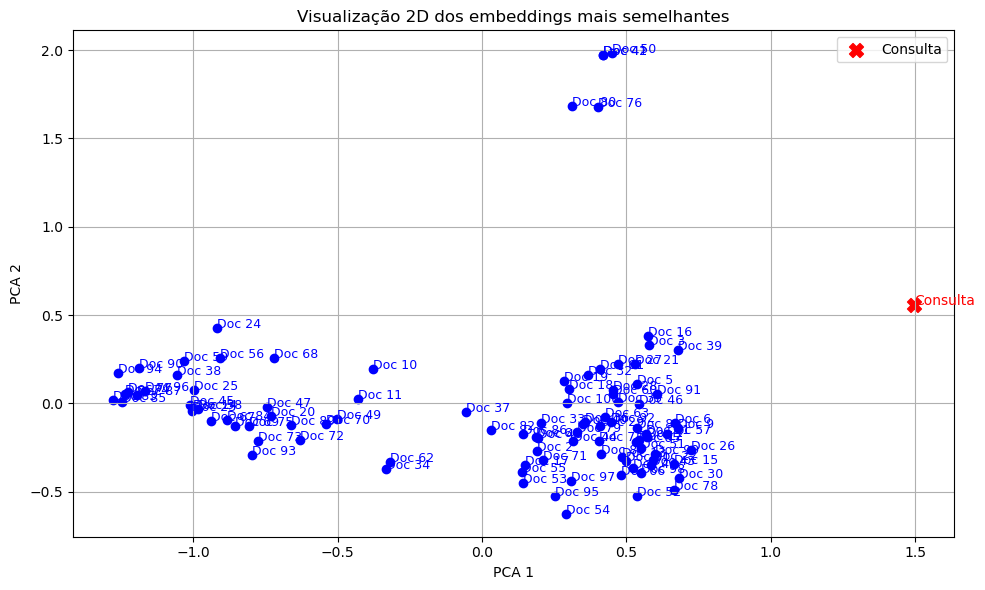

In [64]:
# Plotar os vetores em 2D com PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(np.array(top_embeddings + [query_embedding]))

plt.figure(figsize=(10, 6))

# Plotar documentos
for i in range(top_k):
    plt.scatter(*points_2d[i], color='blue')
    plt.text(points_2d[i][0], points_2d[i][1], f'Doc {i+1}', color='blue', fontsize=9)

# Plotar consulta
plt.scatter(*points_2d[-1], color='red', marker='X', s=100, label='Consulta')
plt.text(points_2d[-1][0], points_2d[-1][1], 'Consulta', color='red', fontsize=10)

plt.title("Visualização 2D dos embeddings mais semelhantes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
#Chamar a IA com o prompt + contexto do RAG
prompt_final = "Dados para consulta: " + texts[sorted_indices[0]] + "\nResponda sobre: " + query

print(prompt_final)
client = Client()
response = client.chat(
    model='mistral',
    messages=[
       
        {"role": "user", "content": prompt_final},
        
    ]
)

print(response['message']['content'])

Dados para consulta:     Selvin E, Steffes MW, Gregg E, Brancati FL, Coresh J. Performance of A1C for
the classi cation and prediction of diabetes. Diabetes Care. 2011 Jan;34(1) 84-
9. doi: 10.2337/dc10-1235. 
    Kumar PR, Bhansali A, Ravikiran M, Bhansali S, Dutta P, Thakur JS, et al. Utility
of glycated hemoglobin in diagnosing type 2 diabetes mellitus: a community-
based study. J Clin Endocrinol Metab. 2010 Jun 1;95(6) 2832–5. 
    Kramer CK, Araneta MRG, Barrett-Connor E. A1C and diabetes diagnosis: The
Responda sobre: Principais Tipos de Diabetes
 Os artigos citados discutem a utilização da hemoglobina glicada (HbA1c) em diagnóstico e previssão de diabetes, além de estudar sua utilidade em diferentes contextos.

O primeiro estudo, conduzido por Selvin et al., publicado no Diabetes Care em 2011, avaliou a performance da HbA1c na classificação e predição de diabetes, utilizando dados do Exame Nacional de Saúde e Nutrição. Os resultados mostraram que a HbA1c tem boa sensibilidade e 